# Exercise 14.X01

In [1]:
# Import the necessary libraries.
import numpy as np
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Import plotting libraries.
import matplotlib.pyplot as plt

# Import pytorch utils.
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader

# Making the process riproducible.
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
_ = g.manual_seed(0)
np.random.seed(seed=None)

# Initialize the device,
device = "cpu"

**STEP 1** 

Produce syntetic data of the functions $ f_1(x) = sin(x)$ and $f_2(x) = e^{sin(x)} $ and plot it. In addition, define the derivatives of $ f_1(x)$ and $f_2(x)$, which are $ f_1'(x) = cos(x)$ and $f_2'(x) = cos(x) * e^{sin(x)} $ respectively; this last information will be used later.

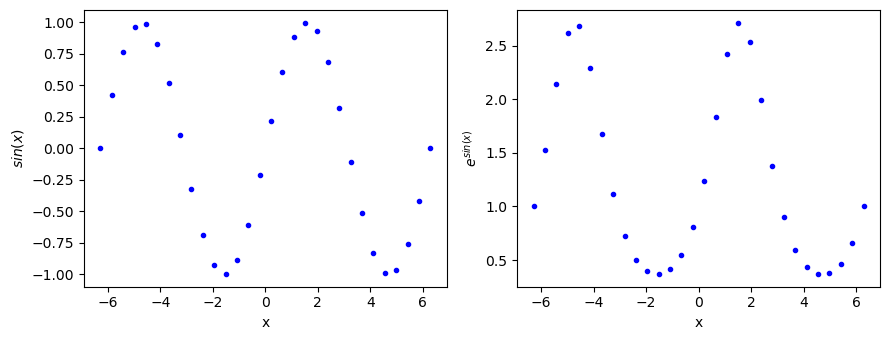

In [2]:
# functions to fit.
def F1( x ):
    """ sin(x) function """
    return np.sin( x )
def F2( x ):
    """ exp(sin(x)) function """
    return np.exp( np.sin( x ) )

# function gradients.
def F1_x( x ):
    """ dsin(x)/dx function """
    return np.cos( x )
def F2_x( x ):
    """ dexp(sin(x))/dx function """
    return np.cos( x ) * np.exp( np.sin( x ) )

# Plotting function.
def plot1( x ):
    
    """ simple function used to plot row data """
    
    # Plot the functions to fit
    fig = plt.figure( figsize = ( 9 , 3.5 ) )
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    for ax , f , ylabel in zip( [ ax1 , ax2 ] , [ F1(x) , F2(x) ] , [ "$sin(x)$" , "$e^{sin(x)}$" ] ):
        ax.plot( x , f , "." , color = "blue" )
        ax.set_xlabel( "x" )
        ax.set_ylabel( ylabel )

    plt.tight_layout()
    plt.plot()

# Define the domain and produce the syntetic data to train the network.    
x = np.linspace( - 2 * np.pi , + 2 * np.pi , num = 30 , endpoint = True )
plot1( x )

**STEP 2** 

Create a *training* and *validation* dataset with ratios $85\%$, $15\%$ of the total dataset respectively, which will be used to train the neural network while also avoiding overfitting. These set of popints contain information about $x$, $f(x)$ and $f'(x)$. The test set will be composed of the training and validation set together. 
 

In [3]:
# Dataset function.
def dataset( x , f , f_x ):
    
    """ This function divide the whole dataset into test, validation and test set.
        The dataset is a matrix n x m , where n = 3 and m = length of the dataset. """
    
    # Chose the trining, validation and test sets ratios.
    L = len(x)
    L_train = int( L  * 0.8 )
    L_val = int( L  * 0.2 )
    
    # Define the set.
    train = np.zeros(( L_train , 3 ))
    val = np.zeros(( L_val , 3 ))

    # Random shuffle to select the pairs non-sequentially.
    idx = np.random.choice( x.shape[0] , L  , replace = False )
    idx_train = idx[ 0 : L_train ]
    idx_val = idx[ L_train : ]
    
    for idx , set_name in zip ( [ idx_train , idx_val ] , [ train, val ] ):
        set_name[ : , 0 ] = np.take( x , idx , axis = 0 )
        set_name[ : , 1 ] = np.take( f , idx , axis = 0 )
        set_name[ : , 2 ] = np.take( f_x , idx , axis = 0 )

    return L_train , L_val , torch.Tensor(train) , torch.Tensor(val) 

# Produce the training, validation and test dataset.
L_train , L_val , train_set1 , val_set1 = dataset( x , F1(x) , F1_x(x) ) 
_ , _ , train_set2 , val_set2 = dataset( x , F2(x) , F2_x(x) ) 

**STEP 3** 

Define the model class, the data-driven loss function and the gradient-informed loss function.

In [4]:
# Neural network.
class net(nn.Module):
    def __init__( self , input_n , h_n , output_n ):
        
        super( net , self ).__init__()
        self.fc1 = nn.Linear( input_n , h_n )
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear( h_n , output_n  )
        
        # Set the initial values of the model's parameters to match the initialization used by Keras.
        init.normal_( self.fc1.weight , mean = 0.0, std = 0.05 )
        init.constant_( self.fc1.bias , 0.0 )
        init.normal_( self.fc2.weight, mean = 0.0, std = 0.05 )
        init.constant_( self.fc2.bias, 0.0 )
        
    def forward( self , x ):
        out = self.fc1( x )
        out = self.tanh1( out )
        out = self.fc2( out )
        
        return out.flatten()
    
# Normal loss function.
def Loss( y , pred , net , x ):
    criterion = nn.MSELoss()
    return criterion( pred , y[ : , 0 ] )
    
# Gradient informed loss function.
def grad_Loss( y, pred, net, x ):
        
    net.require_grad = True

    # compute the derivative of the neural network output w.r.t. the input for all the dataset at once.
    jac = torch.autograd.functional.jacobian( net , x , create_graph = True, strict = False, vectorize = False, strategy = 'reverse-mode')                            
    df_dx = torch.diagonal( jac , 0 )
    
    # compute the MSE of the function and of its gradient.
    criterion = nn.MSELoss()
    criterion_f = criterion( pred.squeeze() , y[ : , 0 ].squeeze() )
    criterion_fx = criterion( df_dx.squeeze() , y[ : , 1 ].squeeze() )
    
    # return the total loss.
    return criterion_f + criterion_fx 

**STEP 4** 

Initialize the models.

In [5]:
# Network parameters.
input_n = 1
output_n = 1
h_n = 50

# Initialize the models.
model1 = net(input_n , h_n , output_n).to(device)
model2 = net(input_n , h_n , output_n).to(device)

**STEP 5** 

Define a function for training the models. Depending on the Loss (data driven or also gradient-informed) passed to the function ```training_loop```, the gradient will be kept in consideration during training.

In [6]:
def training_loop( modela , modelb , train_seta , train_setb , val_seta , val_setb ,\
                  criterion , epochs = 10000 , batch_size_train = L_train , batch_size_val = L_val):
    
    optimizera = torch.optim.Adam( modela.parameters(), lr = 0.005 )
    optimizerb = torch.optim.Adam( modelb.parameters(), lr = 0.005 )

    modela.train()
    modelb.train()

    la = []
    lb = []
    lva = []
    lvb = []

    for epoch in range( epochs ):
    
        c_train = torch.randperm( batch_size_train )
        c_val = torch.randperm( batch_size_val )
    
        train_shuffleda = train_seta[ c_train , : ]
        train_shuffledb = train_setb[ c_train , : ]
    
        val_shuffleda = val_seta[ c_val , : ]
        val_shuffledb = val_setb[ c_val , : ]
    
        modela.zero_grad()
        modelb.zero_grad()
    
        optimizera.zero_grad()
        optimizerb.zero_grad()
    
        preda = modela( train_shuffleda[ : , None , 0 ] )
        predb = modelb( train_shuffledb[ : , None , 0 ] )
    
        lossa = criterion( train_shuffleda[ : , 1: ] , preda , modela , train_shuffleda[ : , None , 0 ] )
        lossb = criterion( train_shuffledb[ : , 1: ] , predb , modelb , train_shuffledb[ : , None , 0 ] )
    
        # validation step.
        val_preda = modela( val_shuffleda[ : , None , 0 ] )
        val_predb = modelb( val_shuffledb[ : , None , 0 ] )
    
        val_lossa = criterion( val_shuffleda[ : , 1: ] , val_preda , modela , val_shuffleda[ : , None , 0 ] )
        val_lossb = criterion( val_shuffledb[ : , 1: ] , val_predb , modelb , val_shuffledb[ : , None , 0 ] )
    
        # write losses on a file before optimization step.
        la.append(lossa.detach().numpy())
        lb.append(lossb.detach().numpy())
        lva.append(val_lossa.detach().numpy())
        lvb.append(val_lossb.detach().numpy())
    
        #monitor val loss
        if val_lossa < 0.0001 and val_lossb < 0.0001:
            print(val_lossa)
            print(val_lossb)
            break
    
        lossa.backward()
        lossb.backward()
    
        optimizera.step() 
        optimizerb.step() 
        
    la = np.array(la)
    lb = np.array(lb)
    lva = np.array(lva)
    lvb = np.array(lvb)
    
    return modela , la , lva , modelb , lb , lvb

**STEP 6** 

Train two models, for function $f_1(x)$ and $f_2(x)$ respectively, using the data-driven loss function only. Then plot the respective *trainin* and *validation* loss functions and they show some overfitting in the function $f_2(x)$.

In [7]:
model1 , loss1 , val_loss1 , model2 , loss2 , val_loss2 = training_loop( model1 , model2 , train_set1 , train_set2 , val_set1 , val_set2, Loss )

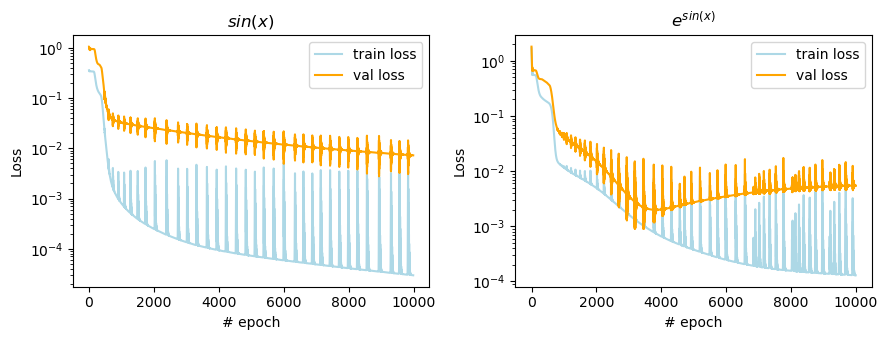

In [8]:
def plot2( la , lb , lva , lvb ):
    
    """ simple function used to plot the losses """
    
    LA = np.vstack( ( la , lva ) )
    LB = np.vstack( ( lb , lvb ) )
    
    # Plot the functions to fit
    fig = plt.figure( figsize = ( 9 , 3.5 ) )
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    for ax , loss , title in zip( [ ax1 , ax2 ] , [ LA , LB ] , [ "$sin(x)$" , "$e^{sin(x)}$" ] ):
        ax.plot( loss[ 0 , 10: ] , color = "lightblue" , label = "train loss" )
        ax.plot( loss[ 1 , 10: ] , color = "orange" , label = "val loss" )
        ax.set_xlabel( "# epoch" )
        ax.set_yscale('log')
        ax.set_ylabel( "Loss" )
        ax.set_title( title )
        ax.legend( loc = "upper right" )

    plt.tight_layout()
    plt.plot()

plt.close()    
plot2( loss1 , loss2 , val_loss1 , val_loss2 )

**STEP 7** 

Make predictions on a larger dataset to asses how the networks interpolate, then, plot the predictions againts the data and the respective errors for the functions ($ f_1(x) = sin(x)$ and $f_2(x) = e^{sin(x)} $ ) and their gradients ($ f_1'(x) = cos(x)$ and $f_2'(x) = cos(x) * e^{sin(x)} $).

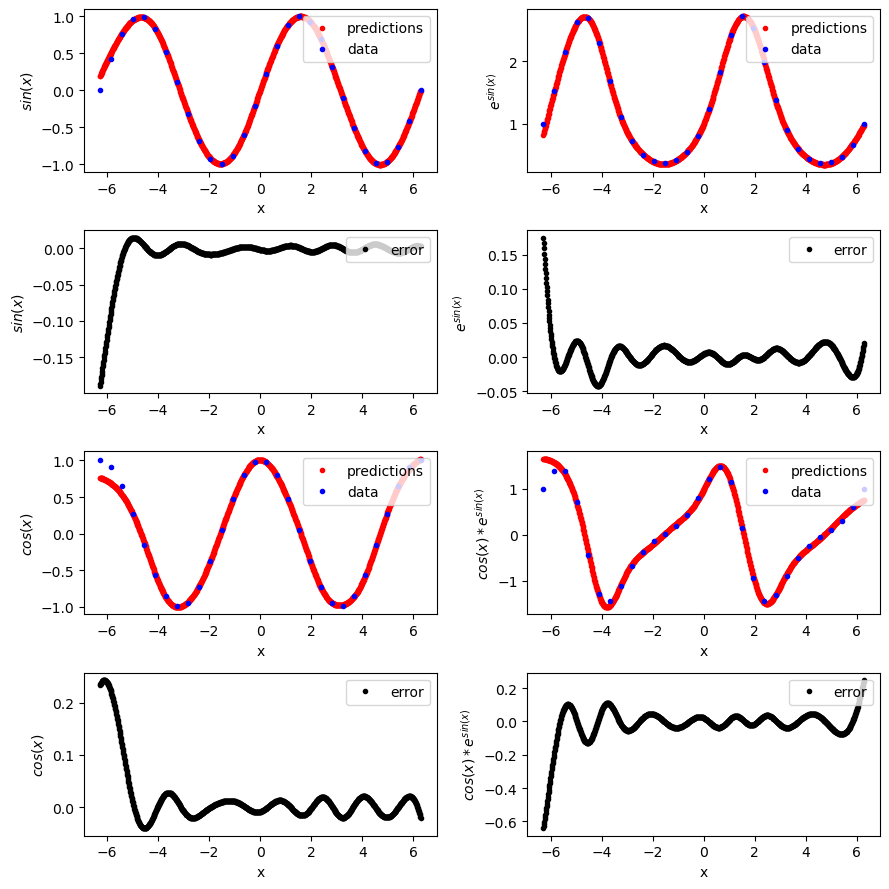

In [9]:
model1.eval()
model2.eval()

x_pred = torch.Tensor( np.linspace( - 2 * np.pi , + 2 * np.pi , num = 1000 , endpoint = True ) )

pred1 = model1( x_pred[ : , None ] )
pred2 = model2( x_pred[ : , None ] )

# Compute the gradient of the networks
model1.require_grad = True
model2.require_grad = True

jac1 = torch.autograd.functional.jacobian( model1 , x_pred[ : , None ] , create_graph = True, strict = False, vectorize = False, strategy = 'reverse-mode')                            
df_dx1 = torch.diagonal( jac1 , 0 )
jac2 = torch.autograd.functional.jacobian( model2 , x_pred[ : , None ] , create_graph = True, strict = False, vectorize = False, strategy = 'reverse-mode')                            
df_dx2 = torch.diagonal( jac2 , 0 )

def plot3( x , x_pred , pa , pb , pa_dx , pb_dx ):
    
    """ simple function used to plot the predictions """
    
    # Plot the functions to fit
    fig = plt.figure( figsize = ( 9 , 9 ) )
    ax1 = fig.add_subplot(421)
    ax2 = fig.add_subplot(422)
    ax3 = fig.add_subplot(423)
    ax4 = fig.add_subplot(424)
    ax5 = fig.add_subplot(425)
    ax6 = fig.add_subplot(426)
    ax7 = fig.add_subplot(427)
    ax8 = fig.add_subplot(428)  

    for ax , f , p , ylabel in zip( [ ax1 , ax2 , ax5 , ax6 ] , [ F1(x) , F2(x) , F1_x(x) , F2_x(x) ] , [ pa.squeeze() , pb.squeeze() , \
                                    pa_dx.squeeze() , pb_dx.squeeze()] , [ "$sin(x)$" , "$e^{sin(x)}$" , "$cos(x)$" , "$cos(x)*e^{sin(x)}$" ] ):
        ax.plot( x_pred , p , "." , color = "red" , label = "predictions" )
        ax.plot( x , f , "." , color = "blue" , label = "data" )
        ax.set_xlabel( "x" )
        ax.set_ylabel( ylabel )
        ax.legend( loc = "upper right" )
        
    for ax , y , ylabel in zip( [ ax3 , ax4 , ax7 , ax8 ] , [ (F1(x_pred) - pa.squeeze()) , (F2(x_pred) - pb.squeeze() ) , (F1_x(x_pred) - pa_dx.squeeze()) , \
                                (F2_x(x_pred) - pb_dx.squeeze())] , [ "$sin(x)$" , "$e^{sin(x)}$" , "$cos(x)$" , "$cos(x)*e^{sin(x)}$" ]  ): 
        ax.plot( x_pred , y , "." , color = "black" , label = "error" )
        ax.set_xlabel( "x" )
        ax.set_ylabel( ylabel )
        ax.legend( loc = "upper right" )

    plt.tight_layout()
    plt.plot()

plt.close()    
plot3( x , x_pred.detach().numpy() , pred1.detach().numpy() , pred2.detach().numpy() , df_dx1.detach().numpy() , df_dx2.detach().numpy() )

**STEP 8** 

Define two new pytorch models equal to the previous ones. Then, train them in the same condition as before but using a loss which minimize both:
- the MSE between the network predictions and the data.
- the MSE between the derivatives of the network and the derivatives of the data.

Evaluate the models and reproduce the same plot as before; once again we can see that the network tends to overfit $f_2(x)$.

In [10]:
# Initialize the models.
model3 = net( input_n , h_n , output_n).to(device)
model4 = net( input_n , h_n , output_n).to(device)

# Train the models using the additional information about the gradient.
model3 , loss3 , val_loss3 , model4 , loss4 , val_loss4 = training_loop( model3 , model4 , train_set1 , train_set2 , val_set1 , val_set2, grad_Loss )

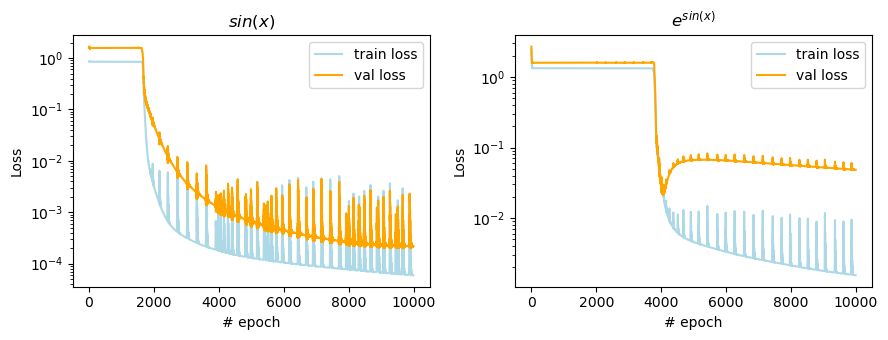

In [11]:
# Plot the loss functions.
plt.close()    
plot2( loss3 , loss4 , val_loss3 , val_loss4 )

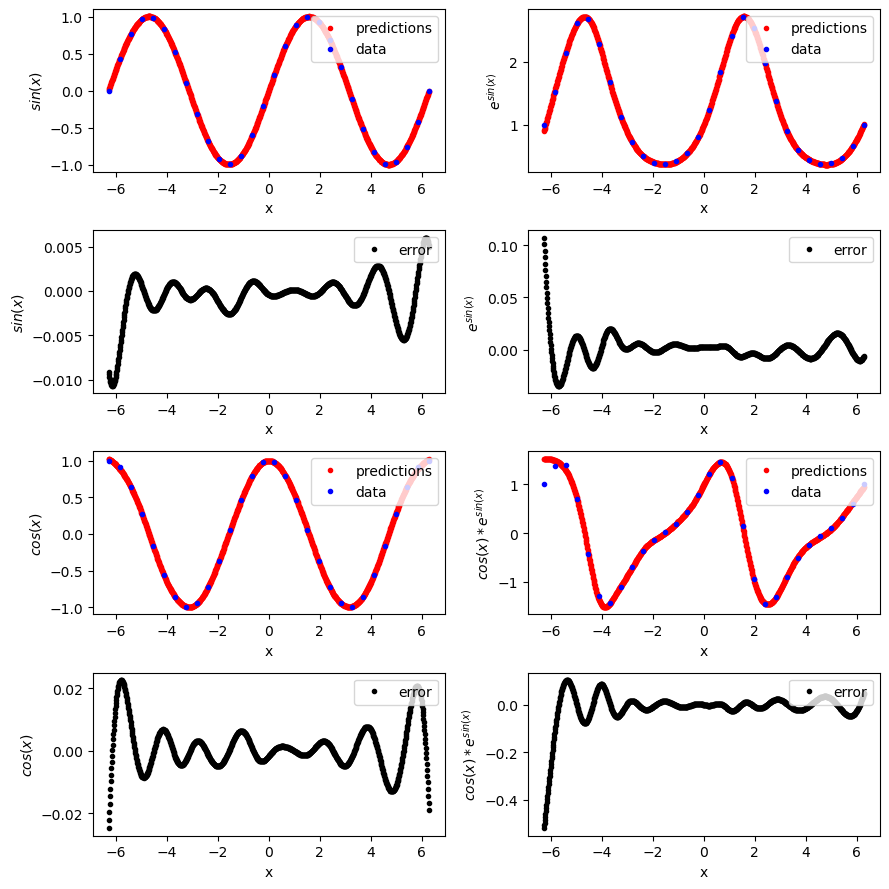

In [12]:
# Evaluate the models on a larger test set.
model3.eval()
model4.eval()

x_pred = torch.Tensor( np.linspace( - 2 * np.pi , + 2 * np.pi , num = 1000 , endpoint = True ) )

pred3 = model3( x_pred[ : , None ] )
pred4 = model4( x_pred[ : , None ] )

# Compute the gradient of the networks
model3.require_grad = True
model4.require_grad = True

jac3 = torch.autograd.functional.jacobian( model3 , x_pred[ : , None ] , create_graph = True, strict = False, vectorize = False, strategy = 'reverse-mode')                            
df_dx3 = torch.diagonal( jac3 , 0 )
jac4 = torch.autograd.functional.jacobian( model4 , x_pred[ : , None ] , create_graph = True, strict = False, vectorize = False, strategy = 'reverse-mode')                            
df_dx4 = torch.diagonal( jac4 , 0 )


# Plot the final results.
plt.close()    
plot3( x , x_pred.detach().numpy() , pred3.detach().numpy() , pred4.detach().numpy() , df_dx3.detach().numpy() , df_dx4.detach().numpy() )

In [13]:
MSE = nn.MSELoss()
MSE1 = MSE( F1(x_pred) , pred1 )
MSE2 = MSE( F2(x_pred) , pred2 )
MSE1_grad = MSE( F1(x_pred) , pred3 )
MSE2_grad = MSE( F2(x_pred) , pred4 )

print("- MSE between predictions and analytical values of sin(x) WO grad information: {:.5f} ".format( MSE1 ) )
print("- MSE between predictions and analytical values of exp(sin(x)) WO grad information: {:.5f} ".format( MSE2 ) )
print("- MSE between predictions and analytical values of sin(x) W grad information: {:.6f} ".format( MSE1_grad ) )
print("- MSE between predictions and analytical values of exp(sin(x)) W grad information: {:.5f} ".format( MSE2_grad ) )

- MSE between predictions and analytical values of sin(x) WO grad information: 0.00081 
- MSE between predictions and analytical values of exp(sin(x)) WO grad information: 0.00046 
- MSE between predictions and analytical values of sin(x) W grad information: 0.000007 
- MSE between predictions and analytical values of exp(sin(x)) W grad information: 0.00016 


The MSE errors computed from the predictions of the four models show that in this particular case, feeding the model with gradient information improve the model capability of riproducing $f_1(x)$ and $f_2(x)$. The magnitude of the improvement is not very large, and if one does not ensure that the entire process is reproducible, it still may happen that the normal model performs better than the physics-informed one. 